In [1]:
# Import modules used for the decision tree classifier & plot
from sklearn import preprocessing, neighbors, naive_bayes, neural_network, svm, tree
from sklearn.metrics import confusion_matrix,  roc_curve, auc
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.decomposition import PCA
from scipy import interp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import tabulate

In [2]:
# Read the csv file, dropping the unnamed id column
# Show the first 5 rows after modification for review
df = pd.read_csv('PD_remove_std_PSF.csv')
df.drop(['Unnamed: 0'], 1, inplace=True)
df.head()

,Status,Gender,MDVP:Jitter(%),MDVP:Jitter(Abs),Jitter:PPQ5,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,RPDE,DFA,PPE
0,1,1.0,-0.054993,0.037705,0.078201,0.062894,-0.201283,-0.233889,-0.190826,-0.228931,-0.208934,-0.190677,0.605835,0.256144,0.627644
1,1,1.0,-0.142570,-0.027844,-0.023255,-0.083360,-0.286750,-0.273123,-0.499987,-0.162993,0.194112,-0.499839,0.368415,-0.080433,0.121620
2,1,1.0,-0.214916,-0.089022,-0.029223,-0.035742,0.734660,0.760052,0.741128,0.876535,0.659075,0.741133,0.733609,-0.349839,0.617950
3,1,0.0,0.710353,1.256904,0.907750,0.899601,-0.301887,-0.207732,-0.466431,-0.464316,-0.316846,-0.466432,0.753631,1.382279,-1.980560
4,1,0.0,1.152045,1.178246,0.663063,1.079867,-0.264860,-0.286201,-0.236462,-0.291184,-0.076256,-0.236313,0.300123,1.398068,-2.472989


In [3]:
# Modify the status of the file
X = np.array(df.drop(['Status'], 1))
y = np.array(df['Status'])

In [4]:
# Data normalization
Z = np.divide((X - X.mean(0)), X.std(0))

In [5]:
# PCA using 14 features
pca = PCA(n_components = 14)
Z_PCA = pca.fit_transform(Z)
print(Z_PCA.shape)

(756, 14)


In [6]:
# KNN
# knn1 = neighbors.KNeighborsClassifier(n_neighbors=7)
knn = neighbors.KNeighborsClassifier(n_neighbors=5)

# Naive Bayes
gnb = naive_bayes.GaussianNB()
gnb_bagging = BaggingClassifier(naive_bayes.GaussianNB(), max_samples = 0.5, max_features = 1.0, n_estimators = 20)

# Support Vector Machine
svmc = svm.SVC(kernel='linear', probability=True,
                     random_state=1)

# Neural Network
nn = neural_network.MLPClassifier(
#                                     activation = 'logistic', 
#                                    solver = 'sgd', 
#                                    max_iter=3000, 
#                                    learning_rate_init = 0.001, 
#                                    momentum = 0.9, 
#                                    epsilon = 1e-04, 
                                   hidden_layer_sizes = (500, 500, 200), 
                                   random_state = 42)
# Decision Tree
dt = tree.DecisionTreeClassifier(random_state = 42)
dt_boost = AdaBoostClassifier(random_state = 42, base_estimator=tree.DecisionTreeClassifier(random_state = 42, max_depth=1), n_estimators= 100, learning_rate = 1)
boost = AdaBoostClassifier(n_estimators= 100)
vote = VotingClassifier(estimators=[('dt', dt_boost), ('knn', knn), ('nn', nn), ('gnb', gnb)],
                          voting='soft', weights=[1, 1, 1, 1])

<ipython-input-7-30cdfe7ad311>:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
<ipython-input-7-30cdfe7ad311>:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
<ipython-input-7-30cdfe7ad311>:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
<ipython-input-7-30cdfe7ad311>:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
<ipython-input-7-30cdfe7ad311>:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


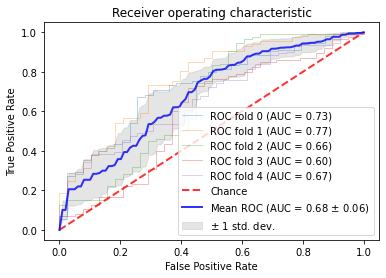

In [7]:
folds = 5
cv = StratifiedKFold(n_splits=folds)

# Classifiers: 
# Decision Tree: dt
# Decision Tree (with boosting): dt_boost
# MLP: nn
# Gaussian Naive Bayes: gnb
# KNN: knn

classifier = dt_boost
inp = Z

acc = np.zeros(folds)
confm = np.zeros((2, 2))

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

# Split the test and train sets
i = 0
for train, test in cv.split(inp, y):
    probas_ = classifier.fit(inp[train], y[train]).predict_proba(inp[test])
    # Compute accuracy
    y_pred = classifier.predict(inp[test])
    acc[i] = (y_pred == y[test]).mean()
    # Confusion matrix
    confm = confm + confusion_matrix(y[test], y_pred)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1
    
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [8]:
'{:.2f}% +- {:.2f}%'.format(acc.mean() * 100, acc.std() * 100)

'75.27% +- 4.48%'

In [9]:
cm = np.zeros((3,3))

In [10]:
cm[0:2, 0:2] = confm
cm[0,2] = (cm[0,0] / cm[0,0:2].sum())* 100
cm[1,2] = (cm[1,1] / cm[1,0:2].sum())* 100
cm[2,0] = (cm[0,0] / cm[0:2,0].sum())* 100
cm[2,1] = (cm[1,1] / cm[0:2,1].sum())* 100

In [13]:
display(HTML(tabulate.tabulate(cm, tablefmt='html')))

69,123,35.9375
64,500,88.6525
51.8797,80.2568,0
